# Shifting moons 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from IPython.display import HTML

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [27]:
def rotation_matrix(angle):
    """
    Create a rotation matrix that rotates the
    space 'angle'-degrees.
    """
    R = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return R

(-1.441703559065854, 2.301093671661471, -0.78454029570558, 1.1810682801472723)

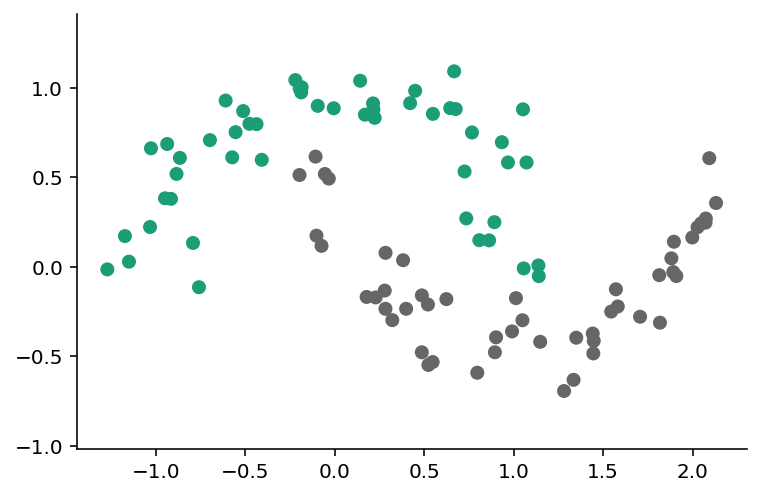

In [108]:
fig, ax = plt.subplots()

X, y = make_moons(n_samples=100, noise=0.12, random_state=314)
ax.scatter(*X.T, c=y, cmap="Dark2")
plt.axis("equal")

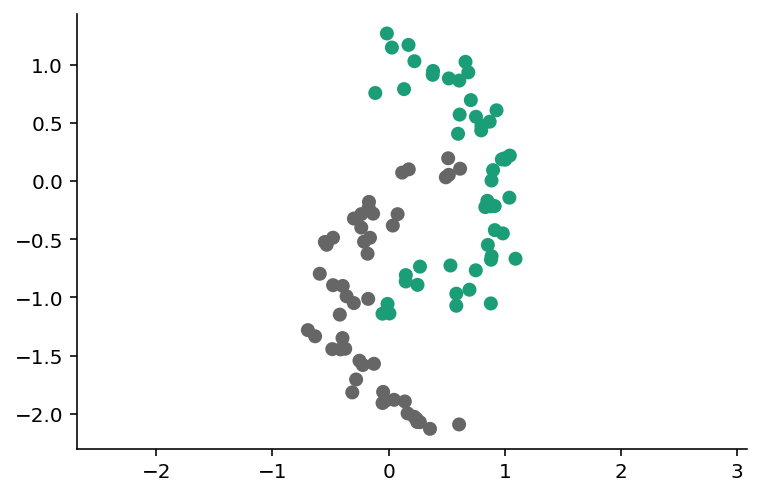

In [111]:
fig, ax = plt.subplots()

R = rotation_matrix(np.pi/2)
X_rot = np.einsum("ni,ij->nj", X, R)
plt.scatter(*X_rot.T, c=y, cmap="Dark2")
plt.axis("equal");

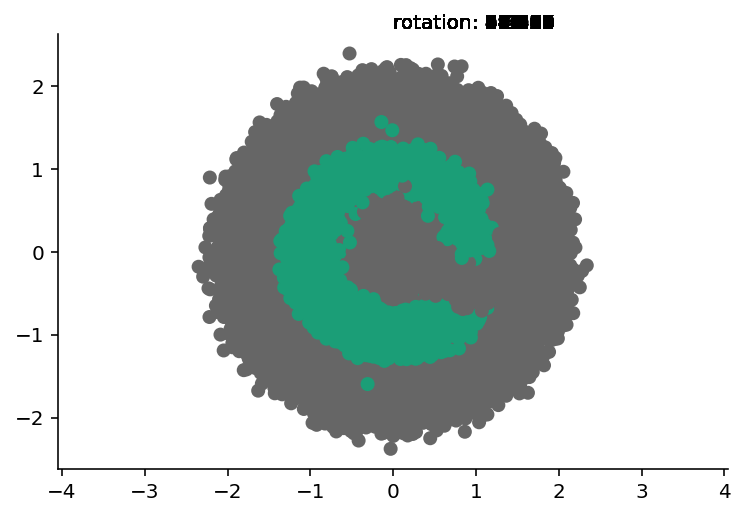

In [112]:
from celluloid import Camera
fig, ax = plt.subplots()
camera = Camera(fig)

for deg in np.linspace(0, 2 * np.pi, 300):
    X, y = make_moons(n_samples=100, noise=0.12)
    R = rotation_matrix(deg)
    X_rot = np.einsum("ni,ij->nj", X, R)
    plt.scatter(*X_rot.T, c=y, cmap="Dark2")
    plt.axis("equal")
    ax.text(0.5, 1.01, f"rotation: {deg * 180 / np.pi:0.2f}", transform=ax.transAxes)
    camera.snap()

In [113]:
animation = camera.animate(interval=25)
HTML(animation.to_html5_video())
#animation.save("rotating-moons.mp4", dpi=200)

## References
1. https://en.wikipedia.org/wiki/Rotation_matrix